In [12]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [14]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=4)

In [15]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [16]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

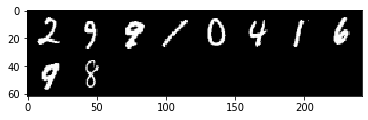

tensor([2, 9, 9, 1, 0, 4, 1, 6, 9, 8])


In [17]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [18]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = NN()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trainloader) - 1
    mult = (final_value/init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    log_lrs = []
    losses = []
    losses_true = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        avg_loss = beta * avg_loss + (1-beta)*loss.item()
        smoothed_loss = avg_loss / (1 - beta**(i+1))

        if i > 0 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses, losses_true

        if smoothed_loss < best_loss or i == 0:
            best_loss = smoothed_loss

        #Store the values
        losses_true.append(loss.item())
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))

        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses, losses_true

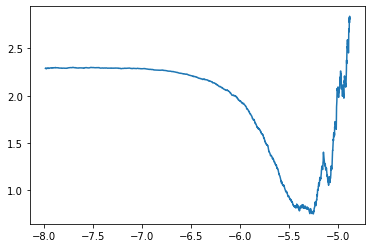

In [21]:
logs,losses, losses_tr = find_lr()
plt.plot(logs[10:-5],losses[10:-5])

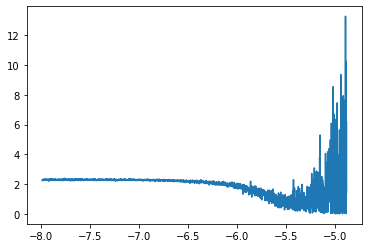

In [22]:
plt.plot(logs[10:-5],losses_tr[10:-5])

In [14]:
%%time
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0]
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.163
[1,  4000] loss: 0.167
[1,  6000] loss: 0.156
[2,  2000] loss: 0.145
[2,  4000] loss: 0.144
[2,  6000] loss: 0.128
Finished Training
Wall time: 39.3 s


In [26]:
correct = 0
total = 0
#net.to('cpu')
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %
